Deleted 0 images
Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.
Epoch 1/3
586/586 [==============================] - 3821s 7s/step - loss: 0.6441 - accuracy: 0.6502 - val_loss: 0.5468 - val_accuracy: 0.7186
Epoch 2/3
586/586 [==============================] - 2183s 4s/step - loss: 0.4913 - accuracy: 0.7626 - val_loss: 0.9343 - val_accuracy: 0.6486
Epoch 3/3
586/586 [==============================] - 2203s 4s/step - loss: 0.3932 - accuracy: 0.8289 - val_loss: 0.4185 - val_accuracy: 0.8104
This image is 60.82 percent cat and 39.18 percent dog.


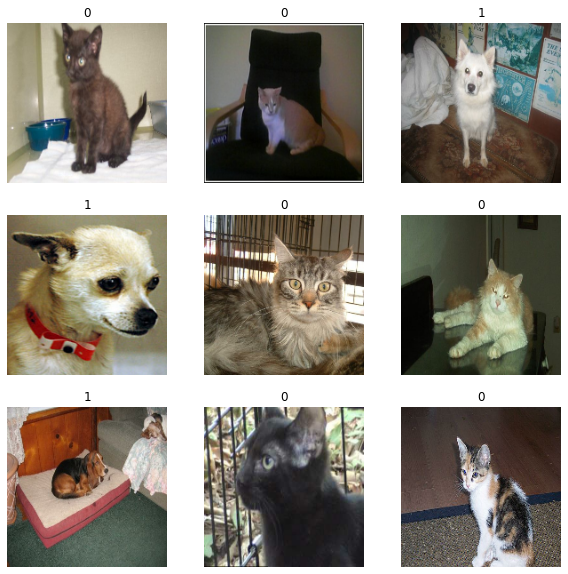

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os


image_size = (180, 180)
batch_size = 32


def train_and_save():
    import os

    num_skipped = 0
    for folder_name in ("Cat", "Dog"):
        folder_path = os.path.join("PetImages", folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

    print("Deleted %d images" % num_skipped)


    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "PetImages",
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "PetImages",
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
    # plt.show()

    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )


    train_ds = train_ds.prefetch(buffer_size=32)
    val_ds = val_ds.prefetch(buffer_size=32)


    def make_model(input_shape, num_classes):
        inputs = keras.Input(shape=input_shape)
        # Image augmentation block
        x = data_augmentation(inputs)

        # Entry block
        x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
        x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(64, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        previous_block_activation = x  # Set aside residual

        for size in [128, 256, 512, 728]:
            x = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(size, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(size, 3, padding="same")(x)
            x = layers.BatchNormalization()(x)

            x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

            # Project residual
            residual = layers.Conv2D(size, 1, strides=2, padding="same")(
                previous_block_activation
            )
            x = layers.add([x, residual])  # Add back residual
            previous_block_activation = x  # Set aside next residual

        x = layers.SeparableConv2D(1024, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.GlobalAveragePooling2D()(x)
        if num_classes == 2:
            activation = "sigmoid"
            units = 1
        else:
            activation = "softmax"
            units = num_classes

        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(units, activation=activation)(x)
        return keras.Model(inputs, outputs)

    model = make_model(input_shape=image_size + (3,), num_classes=2)

    epochs = 3

    callbacks = [
        keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    model.fit(
        train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
    )

    model.save('model2.keras')


if not os.path.isfile('model2.keras'):
    train_and_save()
else:
    print('model2 already exists, skipping')


model = keras.models.load_model('model2.keras')

img = keras.preprocessing.image.load_img(
    "PetImages/Cat/5.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)